# Complete Simulation Chain for Visibility Calculation

## Read in Config

In [1]:
import vipy.simulation.utils as ut
import vipy.layouts.layouts as layouts
import astropy.constants as const
from astropy import units as un
import time as t
import numpy as np
%load_ext autoreload
%autoreload 2

In [2]:
# rc = ut.read_config('/net/nfshome/home/sfroese/vipy/config/default.toml')
rc = ut.read_config("../config/default.toml")
array_layout = layouts.get_array_layout('eht')
src_crd = rc['src_coord']

wave1 = const.c/((float(rc['channel'].split(':')[0])-float(rc['channel'].split(':')[1])/2)*10**6/un.second)/un.meter
wave2 = const.c/((float(rc['channel'].split(':')[0])+float(rc['channel'].split(':')[1])/2)*10**6/un.second)/un.meter

## Generate (l,m)-plane / FOV

In [3]:
import vipy.simulation.scan as scan
import matplotlib.pyplot as plt

8.911845086155491e-10


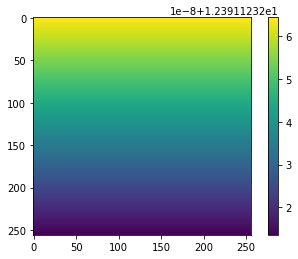

In [4]:
rd = scan.rd_grid(rc['fov_size']*np.pi/(3600*180),256, src_crd)
lm = scan.lm_grid(rd, src_crd)
plt.imshow(np.rad2deg(rd[:,:,1]))
plt.colorbar()
print(rc['fov_size']*np.pi/(3600*180))

## Calculate Start and Stop times for every measurement

In [5]:
time = ut.calc_time_steps(rc)
print(time.shape)

(2232,)


## Calculate Baselines for one measurement

In [6]:
baselines = scan.get_baselines(src_crd, time[:31], array_layout)

In [7]:
baselines.name.shape

(868,)

## Calculate Visibilities

In [8]:
import numpy as np
import torch
from astropy.io import fits
import matplotlib.pyplot as plt

In [9]:
hdul = fits.open('celestial-03-05.fits')
img = hdul[0].data.astype(np.float32)
img = torch.tensor(img)

I = torch.zeros((img.shape[0],img.shape[1],4), dtype=torch.cdouble)
I[...,0] = img
I[...,1] = img
# I[...,2] = img*torch.sqrt(torch.tensor(0.5))
# plt.imshow((I[...,1]+I[...,2]).real)
# plt.colorbar()

In [10]:
%%time
start = t.time()
torch.set_num_threads(8)
X1 = scan.corrupted(lm, baselines, wave1, time[0:31], src_crd, array_layout, I, rd)
X2 = scan.corrupted(lm, baselines, wave2, time[0:31], src_crd, array_layout, I, rd)

CPU times: user 48.7 s, sys: 22.4 s, total: 1min 11s
Wall time: 10.5 s


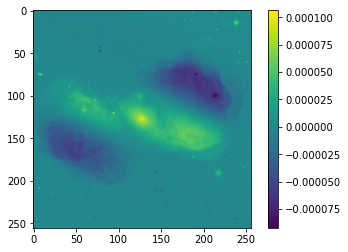

In [11]:
plt.imshow(X1[:,:,5,0,0].real)
plt.colorbar()
plt.show()

## Integration

In [12]:
vis = scan.integrate(X1,X2)
vis.shape

torch.Size([180, 2, 2])

## All scan loop

In [13]:
from tqdm import tqdm

In [14]:
torch.set_num_threads(48)

In [18]:
from dataclasses import dataclass
# stokes, IFs?

@dataclass
class Visibilities:
    I: [complex]
    Q: [complex]
    U: [complex]
    V: [complex]
    num: [int]
    scan: [int]
    base_num: [int]
    u: [float]
    v: [float]
    w: [float]
    date: [float]
    _date: [float]

    def __getitem__(self, i):
        baseline = Vis(
            self.I[i],
            self.Q[i],
            self.U[i],
            self.V[i],
            self.num[i],
            self.scan[i],
            self.base_num[i],
            self.u[i],
            self.v[i],
            self.w[i],
            self.date[i],
            self._date[i],
        )
        return baseline

    def get_values(self):
        return np.array([self.I, self.Q, self.U, self.V])
    
    def add(self, visibilities):
        self.I = np.concatenate([self.I, visibilities.I])
        self.Q = np.concatenate([self.Q, visibilities.Q])
        self.U = np.concatenate([self.U, visibilities.U])
        self.V = np.concatenate([self.V, visibilities.V])
        self.num = np.concatenate([self.num, visibilities.num])
        self.scan = np.concatenate([self.scan, visibilities.scan])
        self.base_num = np.concatenate([self.base_num, visibilities.base_num])
        self.u = np.concatenate([self.u, visibilities.u])
        self.v = np.concatenate([self.v, visibilities.v])
        self.w = np.concatenate([self.w, visibilities.w])
        self.date = np.concatenate([self.date, visibilities.date])
        self._date = np.concatenate([self._date, visibilities._date])
        

@dataclass
class Vis:
    I: complex
    Q: complex
    U: complex
    V: complex
    num: int
    scan: int
    base_num: int
    u: float
    v: float
    w: float
    date: float
    _date: float

In [19]:
hdul = fits.open('/net/big-tank/POOL/users/sfroese/radionets/vlbi/training/staticCelestial/targetImgs/celestial-07-05.fits')
img = hdul[0].data.astype(np.float32)
img = torch.tensor(img)

I = torch.zeros((img.shape[0],img.shape[1],4), dtype=torch.cdouble)
I[...,0] = img
I[...,1] = img
# I[...,2] = img*torch.sqrt(torch.tensor(0.5))

In [21]:
from vipy.simulation.scan import get_valid_baselines
import astropy.units as un
from astropy.time import Time
visibilities = Visibilities([], [], [], [], [], [], [], [], [], [], [], [])
vis_num = np.zeros(1)
#i in total number of scans
for i in tqdm(range(1)):
    t = time[i*31:(i+1)*31]
    baselines = scan.get_baselines(src_crd, t, array_layout)
    
    valid = baselines.valid.reshape(-1, 28)
    mask = np.array(valid[:-1]).astype(bool) & np.array(valid[1:]).astype(bool)
    u = baselines.u.reshape(-1, 28)
    v = baselines.v.reshape(-1, 28)
    w = baselines.w.reshape(-1, 28)
    base_valid = np.arange(len(baselines.u)).reshape(-1, 28)[:-1][mask]
    u_valid = u[:-1][mask]
    v_valid = v[:-1][mask]
    w_valid = w[:-1][mask]
    date = np.repeat((t[:-1]+rc['corr_int_time']*un.second/2).jd.reshape(-1, 1), 28, axis=1)[mask] 
    _date = np.zeros(len(u_valid))    
    
    
    X1 = scan.corrupted(lm, baselines, wave1, time, src_crd, array_layout, I, rd)
    if X1.shape[0] == 1:
        continue
    X2 = scan.corrupted(lm, baselines, wave1, time, src_crd, array_layout, I, rd)
    
    vis_num = np.arange(X1.shape[2]//2) + 1 + vis_num.max()
    

    int_values = scan.integrate(X1, X2)
    int_values = int_values.reshape(-1,4)
    
    vis = Visibilities(
        int_values[:, 0],
        int_values[:, 1],
        int_values[:, 2],
        int_values[:, 3],
        vis_num,
        np.repeat(i+1, len(vis_num)),
        np.array([baselines[i].baselineNum() for i in base_valid]),
        u_valid,
        v_valid,
        w_valid,
        date,
        _date,      
    )
    
    visibilities.add(vis)

100%|██████████| 1/1 [00:11<00:00, 11.78s/it]


In [22]:
import vipy.simulation.utils as ut
import vipy.fits.writer as writer

In [23]:
conf = ut.read_config("../config/default.toml")
conf

{'src_coord': <SkyCoord (ICRS): (ra, dec) in deg
     (187.70593076, 12.39112324)>,
 'fov_size': 0.00018382,
 'corr_int_time': 10.0,
 'scan_start': '2016:95:00:00:00',
 'scan_duration': 300,
 'scans': 72,
 'channel': '227297:4096',
 'interval_length': 1200}

In [24]:
hdu_list = writer.create_hdu_list(visibilities, conf)

[0.50005787 0.50005787 0.50005787 0.50005787 0.50005787 0.50005787
 0.50017361 0.50017361 0.50017361 0.50017361 0.50017361 0.50017361
 0.50028935 0.50028935 0.50028935 0.50028935 0.50028935 0.50028935
 0.50040509 0.50040509 0.50040509 0.50040509 0.50040509 0.50040509
 0.50052083 0.50052083 0.50052083 0.50052083 0.50052083 0.50052083
 0.50063657 0.50063657 0.50063657 0.50063657 0.50063657 0.50063657
 0.50075231 0.50075231 0.50075231 0.50075231 0.50075231 0.50075231
 0.50086806 0.50086806 0.50086806 0.50086806 0.50086806 0.50086806
 0.5009838  0.5009838  0.5009838  0.5009838  0.5009838  0.5009838
 0.50109954 0.50109954 0.50109954 0.50109954 0.50109954 0.50109954
 0.50121528 0.50121528 0.50121528 0.50121528 0.50121528 0.50121528
 0.50133102 0.50133102 0.50133102 0.50133102 0.50133102 0.50133102
 0.50144676 0.50144676 0.50144676 0.50144676 0.50144676 0.50144676
 0.5015625  0.5015625  0.5015625  0.5015625  0.5015625  0.5015625
 0.50167824 0.50167824 0.50167824 0.50167824 0.50167824 0.501678

/scratch/sfroese/envs/radionets/lib/python3.8/site-packages/astropy/io/fits/fitsrec.py:699: UserWarning: Field 2 has a repeat count of 0 in its format code, indicating an empty field.
  warnings.warn(


In [25]:
hdu_list.writeto("test07_eht_Smirnov_crpt.fits", overwrite=True)

In [26]:
hdu_list[0].data

GroupData([(-0.00239224, 0.00238191, -1.79945282e-03, 1286., 0.5000579 , 0., 10., [[[[[[ 3.96852851e-01,  6.47290796e-03,  1.00000000e+00], [ 1.00145720e-01,  1.63343525e-03,  1.00000000e+00], [ 2.20204946e-02,  3.59165249e-04,  1.00000000e+00], [ 5.55699598e-03,  9.06372952e-05,  1.00000000e+00]]]]]]),
           (-0.01390796, 0.02873754,  2.04429263e-04,  264., 0.5000579 , 0., 10., [[[[[[ 7.79838394e-03,  1.27642090e-02,  1.00000000e+00], [-1.46325398e-03, -2.39501940e-03,  1.00000000e+00], [ 1.35056945e-02,  2.21058000e-02,  1.00000000e+00], [-2.53414898e-03, -4.14783508e-03,  1.00000000e+00]]]]]]),
           (-0.02030805, 0.02214667,  8.95961374e-03,  262., 0.5000579 , 0., 10., [[[[[[ 2.35156901e-03,  6.93827961e-03,  1.00000000e+00], [ 5.93410281e-04,  1.75087061e-03,  1.00000000e+00], [ 4.07259353e-03,  1.20161194e-02,  1.00000000e+00], [ 1.02770410e-03,  3.03225871e-03,  1.00000000e+00]]]]]]),
           (-0.01791581, 0.01976476,  1.07590668e-02,  261., 0.5000579 , 0., 10., [[[